In [1]:
#lung cancer detection ct scan

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')


In [3]:
# from zipfile import ZipFile
 
# data_path = 'lung_colon_image_set.zip'
 
# with ZipFile(data_path,'r') as zip:
#   zip.extractall()
#   print('The data set has been extracted.')

In [4]:
path = 'lung_cancer_dataset'
classes = os.listdir(path)
classes

['Bengin cases', 'Malignant cases', 'Normal cases']

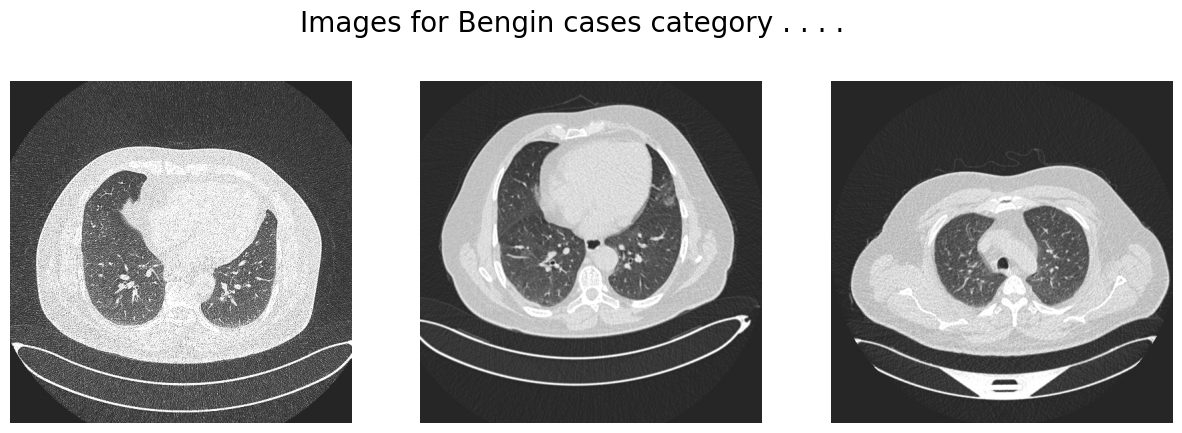

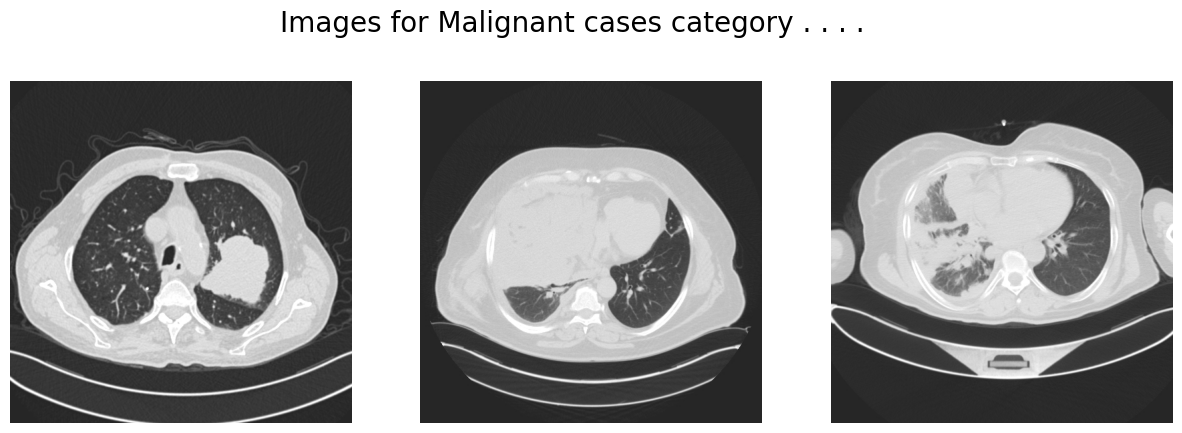

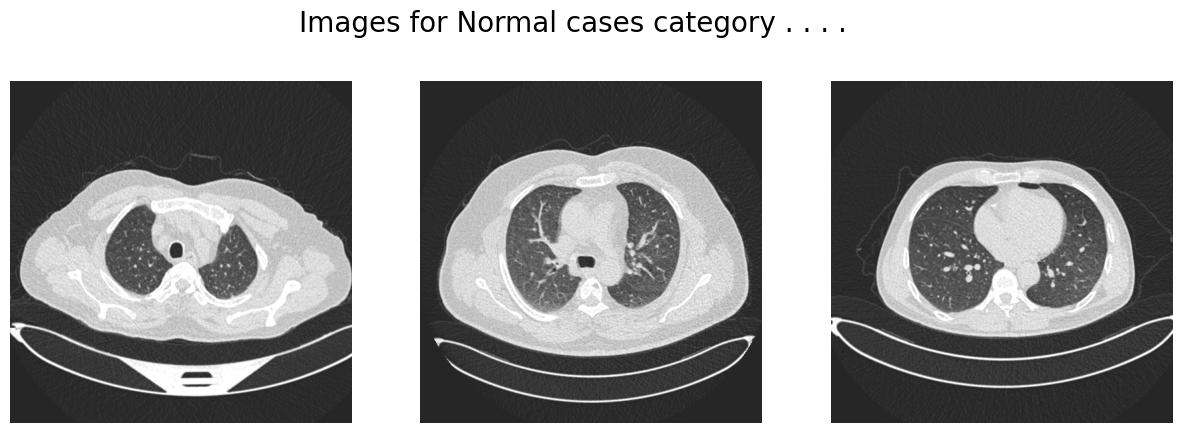

In [5]:
path = 'lung_cancer_dataset'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [6]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 32

In [7]:
X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(877, 256, 256, 3) (220, 256, 256, 3)


In [9]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

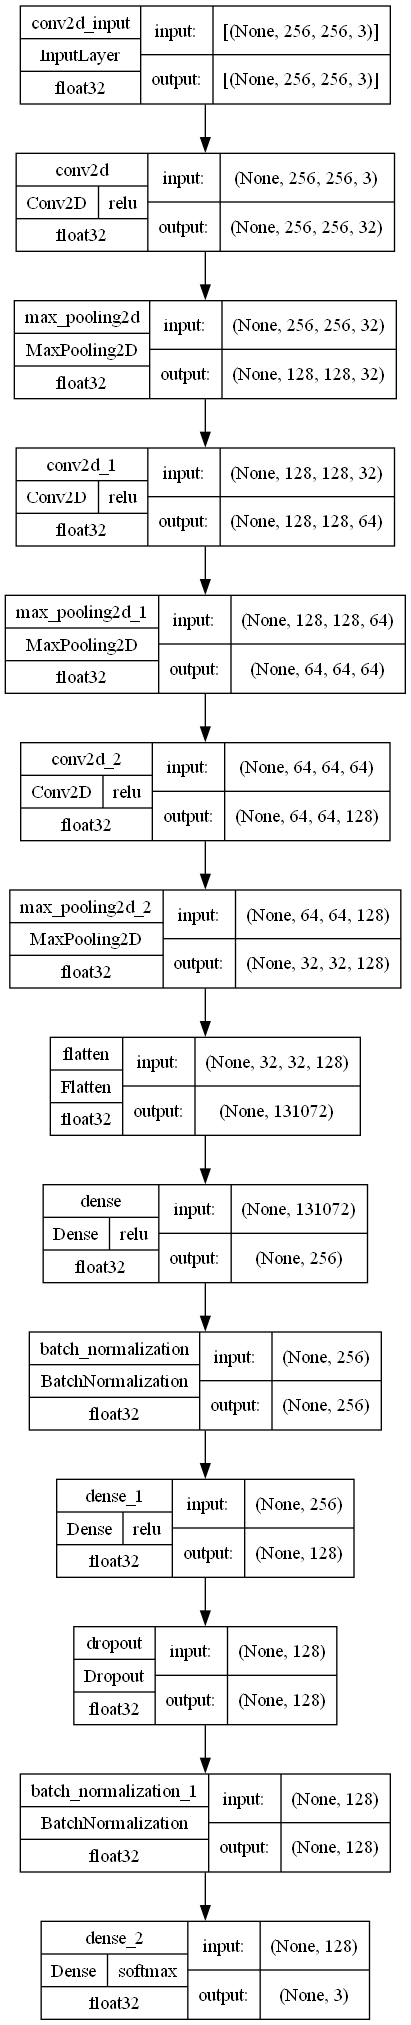

In [11]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)


In [14]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
28/28 [==============================] - 74s 3s/step - loss: 0.7467 - accuracy: 0.7127 - val_loss: 9.9360 - val_accuracy: 0.3955 - lr: 0.0010
Epoch 2/10
28/28 [==============================] - 71s 3s/step - loss: 0.2123 - accuracy: 0.9316 - val_loss: 14.7718 - val_accuracy: 0.4045 - lr: 0.0010
Epoch 3/10
28/28 [==============================] - 69s 2s/step - loss: 0.1079 - accuracy: 0.9669 - val_loss: 5.9617 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 4/10
28/28 [==============================] - 69s 2s/step - loss: 0.0595 - accuracy: 0.9875 - val_loss: 6.5779 - val_accuracy: 0.4182 - lr: 0.0010
Epoch 5/10
28/28 [==============================] - 73s 3s/step - loss: 0.0453 - accuracy: 0.9852 - val_loss: 2.3970 - val_accuracy: 0.4909 - lr: 0.0010
Epoch 6/10
28/28 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9886
 Validation accuracy has reached upto                       90% so, stopping further training.
28/28 [==============================] - 102s

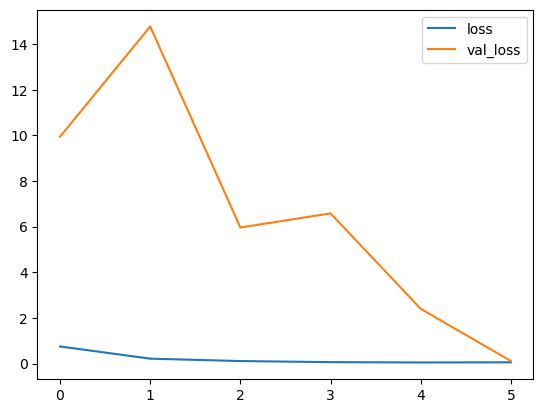

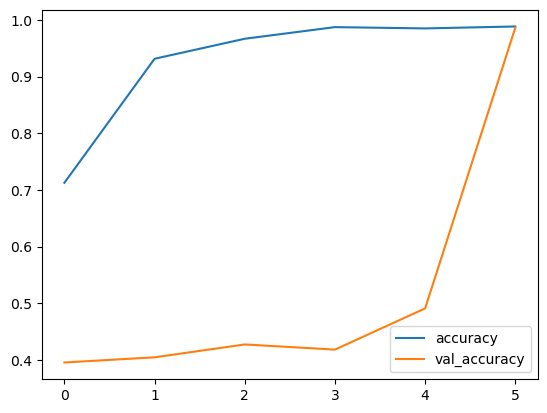

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [16]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

7/7 [==============================] - 7s 825ms/step


In [17]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[ 14,   0,   0],
       [  1, 114,   2],
       [  0,   0,  89]], dtype=int64)

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ['Healthy', 'Benign Tumor', 'Malignant Tumor']

def plot_full_confusion_matrix(Y_val, Y_pred, class_names):
    
    # Compute confusion matrix
    cm = confusion_matrix(Y_val, Y_pred)
    
    plt.figure(figsize=(8, 6))
    
    # Plot the heatmap without annotations
    sns.heatmap(cm, cmap='magma',annot=True , fmt='d' , square=True, cbar=True, linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names)
    
    # Axis labels and title
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

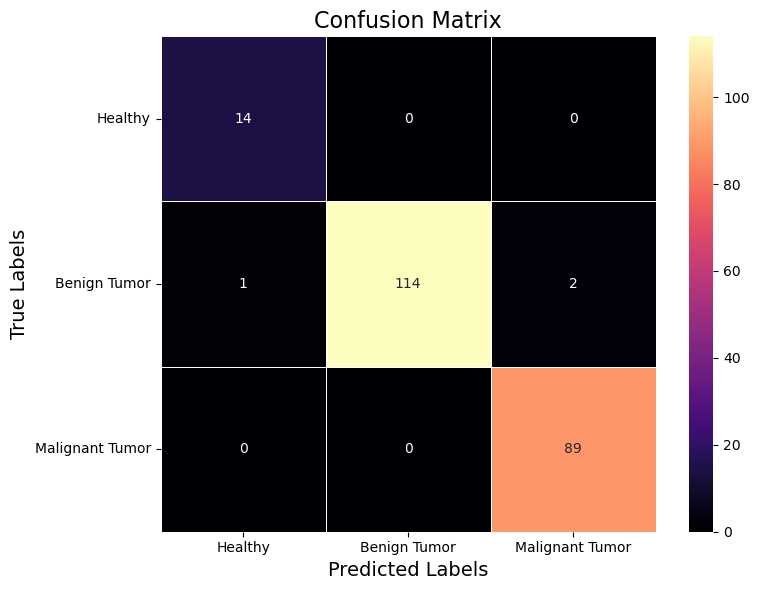

In [19]:
# Plot the half-confusion matrix
plot_full_confusion_matrix(Y_val, Y_pred, class_names)

In [20]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

                 precision    recall  f1-score   support

   Bengin cases       0.93      1.00      0.97        14
Malignant cases       1.00      0.97      0.99       117
   Normal cases       0.98      1.00      0.99        89

       accuracy                           0.99       220
      macro avg       0.97      0.99      0.98       220
   weighted avg       0.99      0.99      0.99       220



In [21]:
model.save('lung_cancer_model.h5')

In [22]:
print('end')

end
